<a href="https://colab.research.google.com/github/mdzikrim/Hands-on_DL/blob/main/Chapter_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(np.int64)

# Normalize data
X = X / 255.0

# One-hot encode labels
def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

# Split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=5000, random_state=42)

y_train_oh = one_hot(y_train, 10)
y_val_oh = one_hot(y_val, 10)


In [3]:
def softmax(logits):
    exp = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    return exp / np.sum(exp, axis=1, keepdims=True)

def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-9)) / m

def predict(X, W, b):
    logits = X.dot(W) + b
    return np.argmax(softmax(logits), axis=1)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)


In [4]:
n_inputs = X.shape[1]   # 784
n_outputs = 10          # digit 0-9

W = np.random.randn(n_inputs, n_outputs) * 0.01
b = np.zeros(n_outputs)


In [5]:
# Hyperparameters
learning_rate = 0.1
n_epochs = 100
batch_size = 1000
patience = 5

# Tracking
best_val_loss = np.inf
patience_count = 0

train_losses, val_losses = [], []

for epoch in range(n_epochs):
    indices = np.random.permutation(X_train.shape[0])
    X_shuffled = X_train[indices]
    y_shuffled = y_train_oh[indices]

    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size]

        logits = X_batch.dot(W) + b
        y_pred = softmax(logits)

        error = y_pred - y_batch
        grad_W = X_batch.T.dot(error) / batch_size
        grad_b = np.mean(error, axis=0)

        W -= learning_rate * grad_W
        b -= learning_rate * grad_b

    # Loss monitoring
    y_train_pred = softmax(X_train.dot(W) + b)
    y_val_pred = softmax(X_val.dot(W) + b)
    train_loss = compute_loss(y_train_oh, y_train_pred)
    val_loss = compute_loss(y_val_oh, y_val_pred)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_count = 0
        best_W, best_b = W.copy(), b.copy()
    else:
        patience_count += 1
        if patience_count >= patience:
            print("Early stopping triggered.")
            break


Epoch 1 | Train Loss: 0.7620 | Val Loss: 0.7646
Epoch 2 | Train Loss: 0.5861 | Val Loss: 0.5859
Epoch 3 | Train Loss: 0.5147 | Val Loss: 0.5118
Epoch 4 | Train Loss: 0.4742 | Val Loss: 0.4701
Epoch 5 | Train Loss: 0.4474 | Val Loss: 0.4421
Epoch 6 | Train Loss: 0.4281 | Val Loss: 0.4222
Epoch 7 | Train Loss: 0.4133 | Val Loss: 0.4072
Epoch 8 | Train Loss: 0.4014 | Val Loss: 0.3949
Epoch 9 | Train Loss: 0.3917 | Val Loss: 0.3846
Epoch 10 | Train Loss: 0.3835 | Val Loss: 0.3766
Epoch 11 | Train Loss: 0.3764 | Val Loss: 0.3696
Epoch 12 | Train Loss: 0.3704 | Val Loss: 0.3633
Epoch 13 | Train Loss: 0.3651 | Val Loss: 0.3577
Epoch 14 | Train Loss: 0.3602 | Val Loss: 0.3530
Epoch 15 | Train Loss: 0.3560 | Val Loss: 0.3493
Epoch 16 | Train Loss: 0.3520 | Val Loss: 0.3451
Epoch 17 | Train Loss: 0.3485 | Val Loss: 0.3417
Epoch 18 | Train Loss: 0.3453 | Val Loss: 0.3387
Epoch 19 | Train Loss: 0.3422 | Val Loss: 0.3360
Epoch 20 | Train Loss: 0.3395 | Val Loss: 0.3332
Epoch 21 | Train Loss: 0.3369

In [6]:
y_test_pred = predict(X_test, best_W, best_b)
test_acc = accuracy(y_test, y_test_pred)
print("Test accuracy:", test_acc)


Test accuracy: 0.917


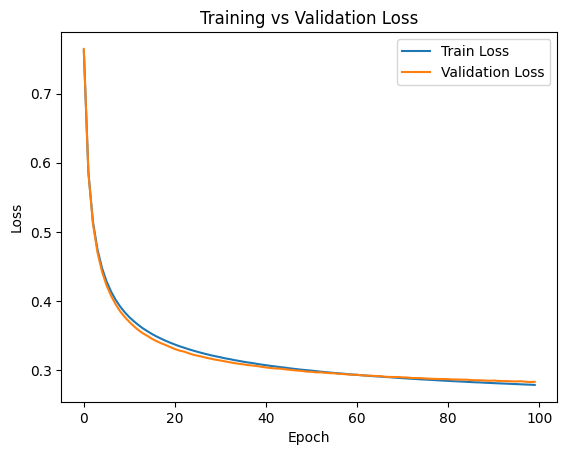

In [7]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()
